In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
import os
from google.colab import files
from kneed import KneeLocator

In [2]:
project_name = "ds_SauravBhadange"
os.makedirs(f"{project_name}/csv_files", exist_ok=True)
os.makedirs(f"{project_name}/outputs", exist_ok=True)


In [12]:
print("Upload both CSV files")
uploaded = files.upload()

for filename in uploaded.keys():
    os.rename(filename, f'/content/ds_SauravBhadange/csv_files/{filename}')

Upload both CSV files


Saving historical_data.csv to historical_data.csv
Saving fear_greed_index.csv to fear_greed_index.csv


In [13]:
trader_df = pd.read_csv('/content/ds_SauravBhadange/csv_files/historical_data.csv')
sentiment_df = pd.read_csv('/content/ds_SauravBhadange/csv_files/fear_greed_index.csv')

In [14]:
trader_df.head()

,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [15]:
sentiment_df.head()

,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


In [16]:

trader_df.columns = trader_df.columns.str.lower()
sentiment_df.columns = sentiment_df.columns.str.lower()

In [30]:
print(trader_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211224 entries, 0 to 211223
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   account           211224 non-null  object 
 1   coin              211224 non-null  object 
 2   execution price   211224 non-null  float64
 3   size tokens       211224 non-null  float64
 4   size usd          211224 non-null  float64
 5   side              211224 non-null  object 
 6   timestamp ist     211224 non-null  object 
 7   start position    211224 non-null  float64
 8   direction         211224 non-null  object 
 9   closed pnl        211224 non-null  float64
 10  transaction hash  211224 non-null  object 
 11  order id          211224 non-null  int64  
 12  crossed           211224 non-null  bool   
 13  fee               211224 non-null  float64
 14  trade id          211224 non-null  float64
 15  timestamp         211224 non-null  float64
dtypes: bool(1), float64(

In [21]:
trader_df.isnull().sum()

,0
account,0
coin,0
execution price,0
size tokens,0
size usd,0
side,0
timestamp ist,0
start position,0
direction,0
closed pnl,0


In [22]:
trader_df.duplicated().sum()

np.int64(0)

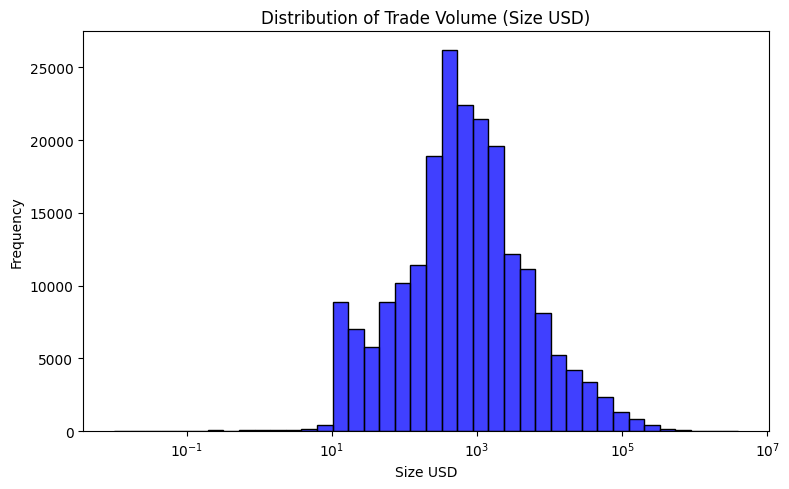

In [27]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=trader_df, x="size usd", bins=40, color="blue", log_scale=(True, False), ax=ax)
ax.set_title("Distribution of Trade Volume (Size USD)")
ax.set_xlabel("Size USD")
ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

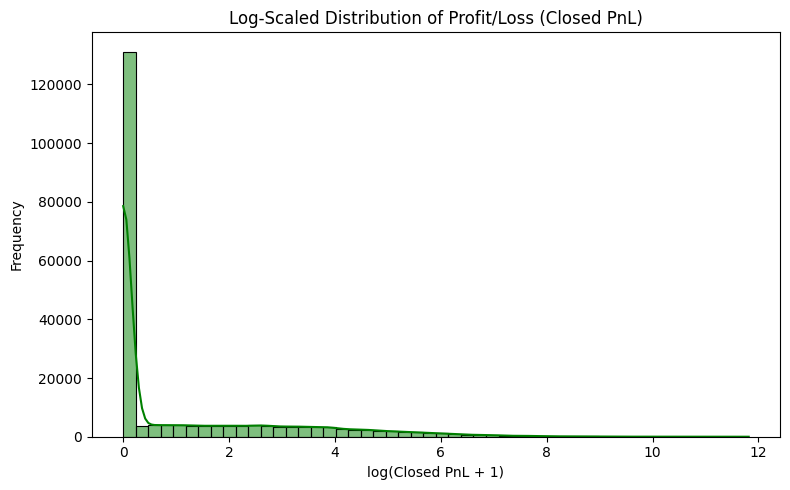

Large values compressed via log scaling, making the shape clearer.


In [26]:
plt.figure(figsize=(8, 5))
pnl = trader_df.get('closed pnl', 0)
log_pnl = np.log1p(np.maximum(pnl, 0))
sns.histplot(log_pnl, bins=50, kde=True, color='green')

plt.title("Log-Scaled Distribution of Profit/Loss (Closed PnL)")
plt.xlabel("log(Closed PnL + 1)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

print("Large values compressed via log scaling, making the shape clearer.")

/tmp/ipython-input-399106088.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=trader_df["side"], palette="Set2", ax=ax)


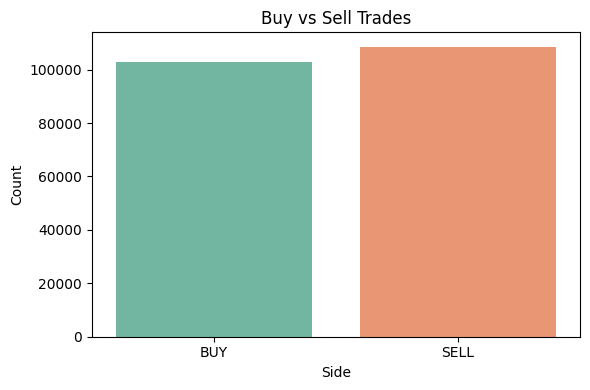

In [29]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(x=trader_df["side"], palette="Set2", ax=ax)

ax.set_title("Buy vs Sell Trades")
ax.set_xlabel("Side")
ax.set_ylabel("Count")
plt.tight_layout()
plt.show()


In [31]:
sentiment_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2644 entries, 0 to 2643
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   timestamp       2644 non-null   int64 
 1   value           2644 non-null   int64 
 2   classification  2644 non-null   object
 3   date            2644 non-null   object
dtypes: int64(2), object(2)
memory usage: 82.8+ KB


In [32]:
sentiment_df.isnull().sum()

,0
timestamp,0
value,0
classification,0
date,0


In [33]:
sentiment_df.duplicated().sum()

np.int64(0)

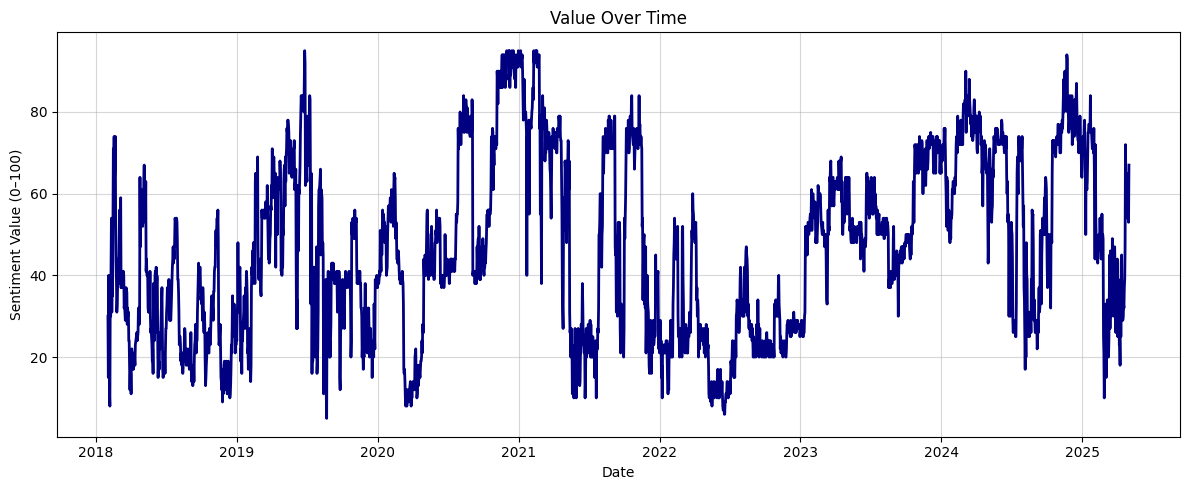

In [34]:
sentiment_df["date"] = pd.to_datetime(sentiment_df["date"], errors="coerce")
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(sentiment_df["date"], sentiment_df["value"], linestyle="-", linewidth=2, color="navy")
ax.set_title("Value Over Time")
ax.set_xlabel("Date")
ax.set_ylabel("Sentiment Value (0–100)")
ax.grid(alpha=0.5)

plt.tight_layout()
plt.show()

/tmp/ipython-input-4277541032.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=sentiment_df, x="classification", order=sentiment_df["classification"].value_counts().index, palette="Set3", ax=ax)


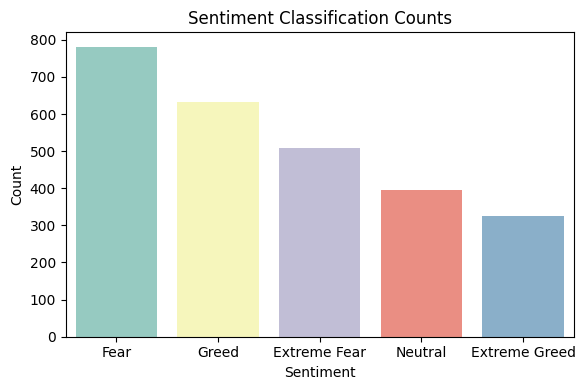

In [35]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.countplot(data=sentiment_df, x="classification", order=sentiment_df["classification"].value_counts().index, palette="Set3", ax=ax)
ax.set_title("Sentiment Classification Counts")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

In [36]:
trader_df['timestamp_ist'] = pd.to_datetime(trader_df['timestamp ist'], errors='coerce', dayfirst=True)
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], errors='coerce')

In [40]:
trader_daily = (trader_df.assign(date=trader_df["timestamp_ist"].dt.normalize()).groupby("date", as_index=False).agg(
        total_pnl=("closed pnl", "sum"),
        total_volume=("size usd", "sum"),
        price_risk=("execution price", "std")
    )
)
trader_daily["date"] = pd.to_datetime(trader_daily["date"])


In [41]:

merged_df = pd.merge(trader_daily, sentiment_df[['date','value']], on='date', how='inner')
merged_df.rename(columns={'value': 'sentiment_score'}, inplace=True)


In [42]:
merged_df["sentiment_norm"] = merged_df["sentiment_score"].apply(
    lambda x: (x - merged_df["sentiment_score"].min()) /
              (merged_df["sentiment_score"].max() - merged_df["sentiment_score"].min()))


In [43]:

merged_df.head()

,date,total_pnl,total_volume,price_risk,sentiment_score,sentiment_norm
0,2023-05-01,0.000000,477.00,0.404145,63,0.630952
1,2023-12-05,0.000000,50005.83,17477.946554,75,0.773810
2,2023-12-14,-205.434737,113203.35,17176.671271,72,0.738095
3,2023-12-15,-24.632034,10609.95,0.000000,70,0.714286
4,2023-12-16,0.000000,15348.77,0.000029,67,0.678571


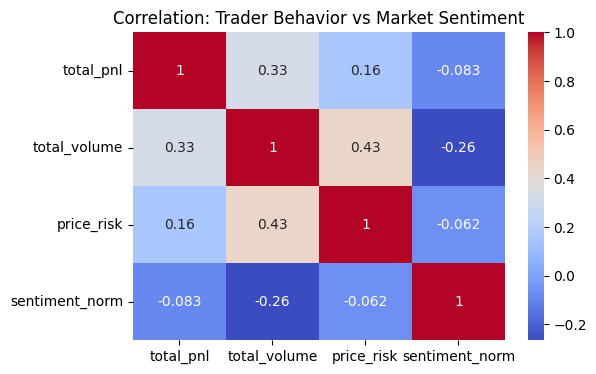

In [44]:
corr = merged_df[['total_pnl','total_volume','price_risk','sentiment_norm']].corr()

fig, ax = plt.subplots(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

ax.set_title("Correlation: Trader Behavior vs Market Sentiment")

fig.savefig('/content/ds_SauravBhadange/outputs/correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()


In [45]:
features = ["total_pnl", "total_volume", "price_risk"]
merged_df[features] = merged_df[features].fillna(0)
merged_df = merged_df.dropna(subset=features)
merged_df = merged_df[~(merged_df[features] == 0).all(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(merged_df[features])

ELBOW METHOD to find Optimal k


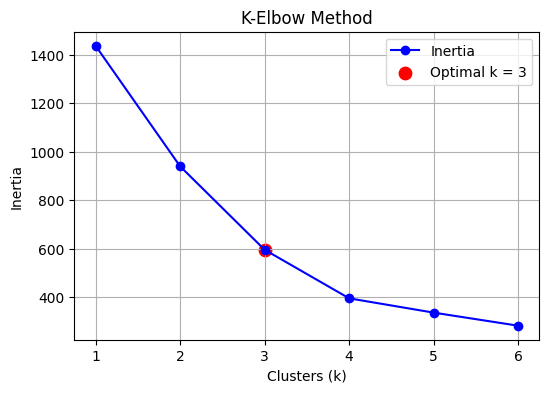

In [49]:
print("ELBOW METHOD to find Optimal k")
inertias = []
K = range(1, 7)
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(scaled)
    inertias.append(km.inertia_)

knee = KneeLocator(K, inertias, curve="convex", direction="decreasing")
optimal_k = knee.knee


fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(K, inertias, "bo-", label="Inertia")
if optimal_k is not None:
    ax.scatter(optimal_k, inertias[optimal_k-1], color="red", s=80,
               label=f"Optimal k = {optimal_k}")

ax.set_xlabel("Clusters (k)")
ax.set_ylabel("Inertia")
ax.set_title("K-Elbow Method")
ax.grid(True)
ax.legend()
fig.savefig("/content/ds_SauravBhadange/outputs/k_elbow_auto.png", dpi=300, bbox_inches="tight")
plt.show()


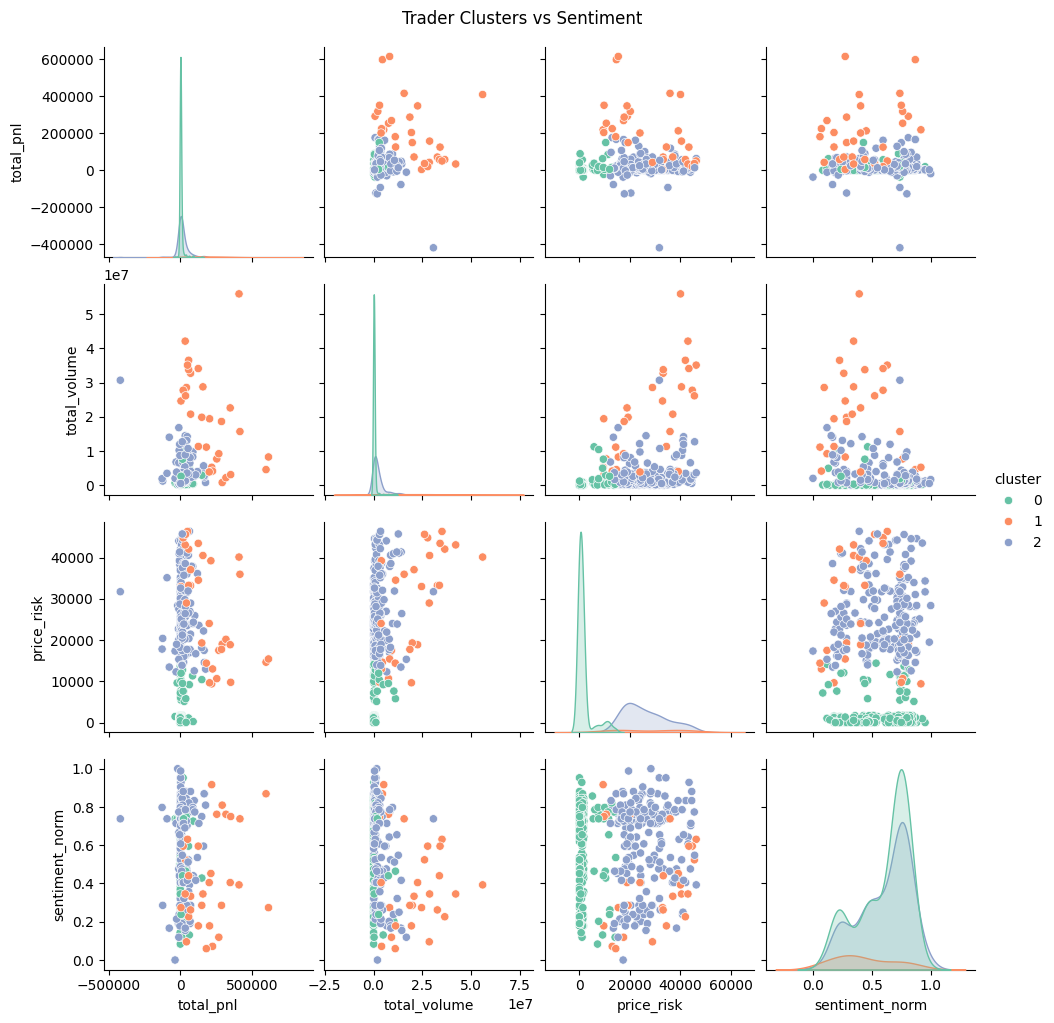

In [50]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
merged_df["cluster"] = kmeans.fit_predict(scaled)

pairplot = sns.pairplot(merged_df, hue="cluster", vars=["total_pnl", "total_volume", "price_risk", "sentiment_norm"], diag_kind="kde", palette="Set2")
pairplot.fig.suptitle("Trader Clusters vs Sentiment", y=1.02)
pairplot.savefig("/content/ds_SauravBhadange/outputs/cluster_pairplot.png",dpi=300,bbox_inches="tight")
plt.show()


In [52]:
features = ["total_pnl", "total_volume", "price_risk", "sentiment_norm"]
cluster_summary = (merged_df.groupby("cluster").agg(
        total_pnl_mean=("total_pnl", "mean"),
        total_volume_mean=("total_volume", "mean"),
        price_risk_mean=("price_risk", "mean"),
        sentiment_norm_mean=("sentiment_norm", "mean"),
        days_in_cluster=("date", "count")
    ).reset_index())
print(cluster_summary)


   cluster  total_pnl_mean  total_volume_mean  price_risk_mean  \
0        0     4013.652690       3.481442e+05      1581.653429   
1        1   207382.412701       1.929864e+07     27573.688237   
2        2    13808.414770       2.458638e+06     26160.101655   

   sentiment_norm_mean  days_in_cluster  
0             0.606599              241  
1             0.431644               31  
2             0.608006              207  


/tmp/ipython-input-4016129381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="cluster", y=metric, ax=ax, palette="coolwarm")
/tmp/ipython-input-4016129381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="cluster", y=metric, ax=ax, palette="coolwarm")
/tmp/ipython-input-4016129381.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_summary, x="cluster", y=metric, ax=ax, palette="coolwarm")
/tmp/ipython-input-4016129381.py:6: FutureWarning: 

Passing `palette` without assign

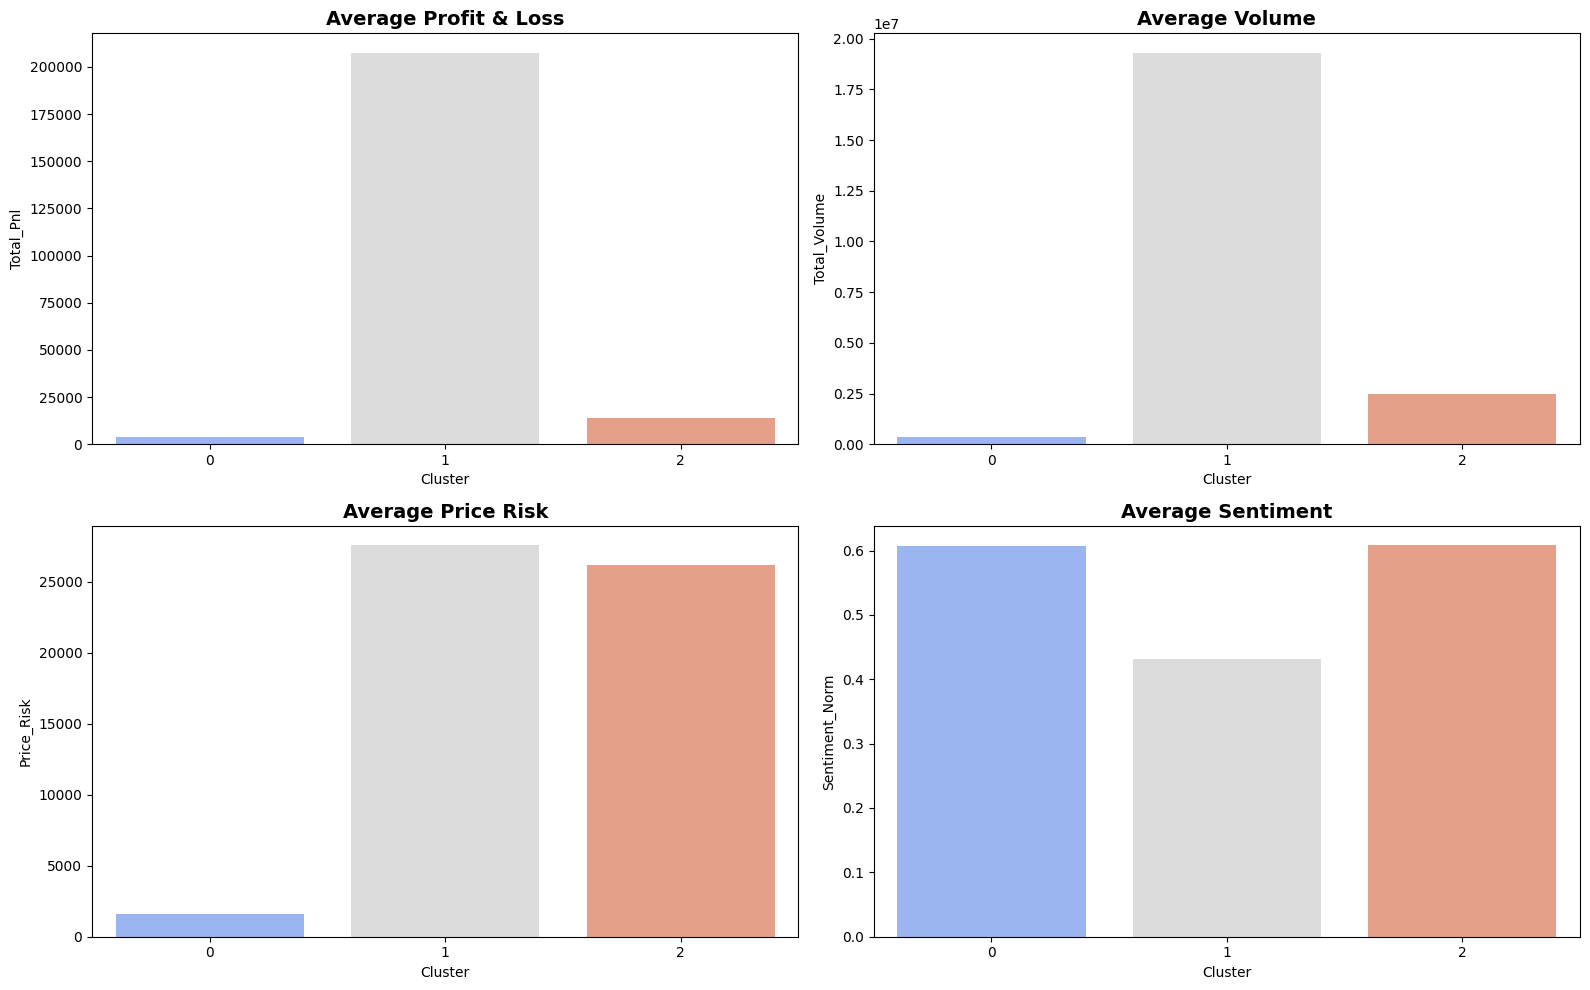

In [53]:
metrics = ["total_pnl_mean", "total_volume_mean", "price_risk_mean", "sentiment_norm_mean"]
titles  = ["Average Profit & Loss", "Average Volume", "Average Price Risk", "Average Sentiment"]

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
for ax, metric, title in zip(axes.flatten(), metrics, titles):
    sns.barplot(data=cluster_summary, x="cluster", y=metric, ax=ax, palette="coolwarm")
    ax.set_title(title, fontsize=14, fontweight="bold")
    ax.set_xlabel("Cluster")
    ax.set_ylabel(metric.replace("_mean", "").title())
plt.tight_layout()
fig.savefig("/content/ds_SauravBhadange/outputs/cluster_metrics.png", dpi=300, bbox_inches="tight")
plt.show()


In [54]:
plt.tight_layout()
fig.savefig("/content/ds_SauravBhadange/outputs/cluster_comparison_bars.png", dpi=300, bbox_inches="tight")
plt.show()

cluster_summary.to_csv("/content/ds_SauravBhadange/csv_files/cluster_summary.csv", index=False)


<Figure size 640x480 with 0 Axes>

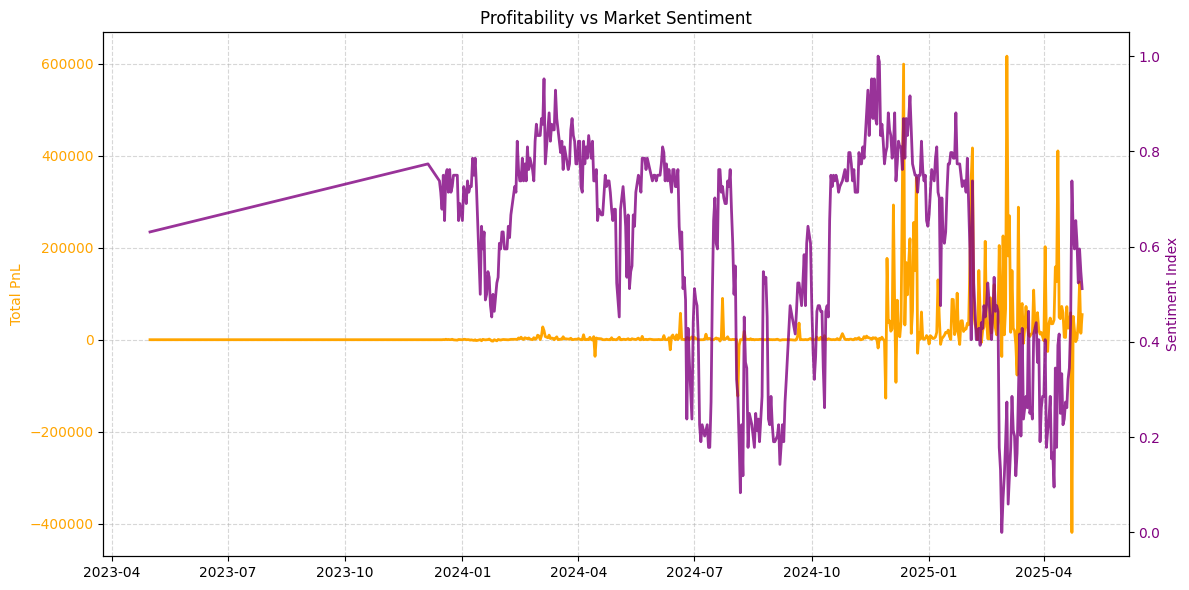

In [59]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged_df['date'], merged_df['total_pnl'], color='orange', linestyle='-', linewidth=2, label='Total PnL')
ax1.set_ylabel('Total PnL', color='orange')
ax1.tick_params(axis='y', labelcolor='orange')
ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['sentiment_norm'], color='purple', linestyle='-', linewidth=2, alpha=0.8, label='Sentiment Index')
ax2.set_ylabel('Sentiment Index', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')
plt.title('Profitability vs Market Sentiment')
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()
fig.savefig('/content/ds_SauravBhadange/outputs/time_series_pnl_sentiment.png')


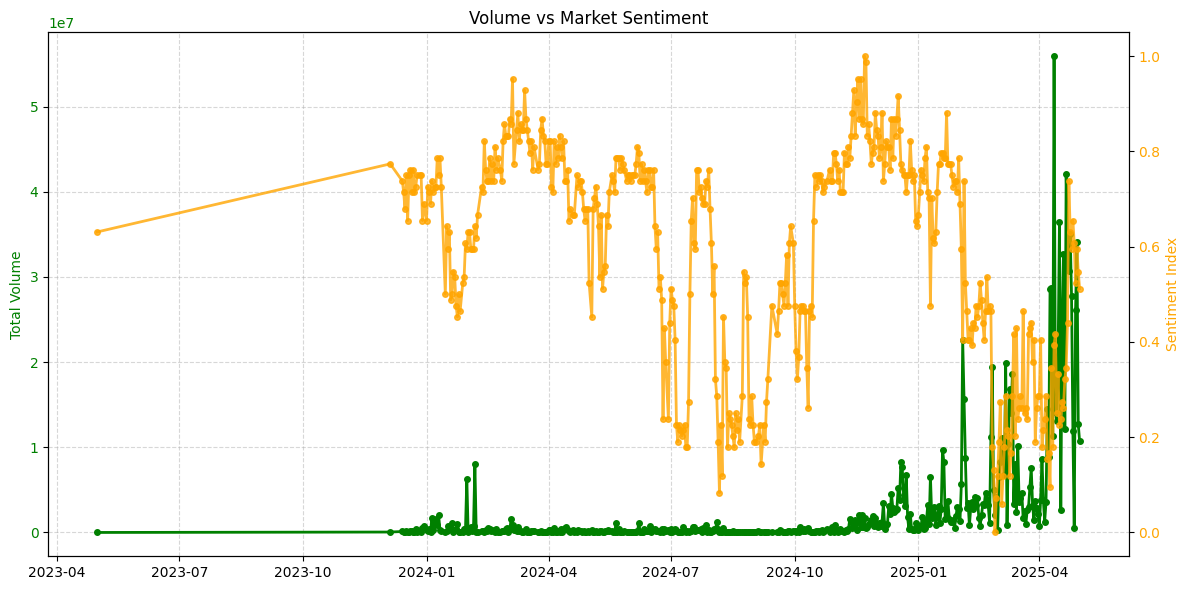

In [62]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(merged_df['date'], merged_df['total_volume'], color='green', linestyle='-', linewidth=2, marker='o', markersize=4, label='Total Volume')
ax1.set_ylabel('Total Volume', color='green')
ax1.tick_params(axis='y', labelcolor='green')

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['sentiment_norm'], color='orange', linestyle='-', linewidth=2, alpha=0.8, marker='o', markersize=4, label='Sentiment Index')
ax2.set_ylabel('Sentiment Index', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
plt.title('Volume vs Market Sentiment')
ax1.grid(True, linestyle='--', alpha=0.5)
fig.tight_layout()
plt.show()
fig.savefig('/content/ds_SauravBhadange/outputs/time_series_volume_sentiment.png')


In [63]:
print("\n=== Regression Analysis: Predicting Total Profit & Loss ===")
regression_data = merged_df[['total_pnl', 'sentiment_norm', 'total_volume', 'price_risk']].copy()
regression_data['sentiment_lag1'] = regression_data['sentiment_norm'].shift(1)
regression_data.dropna(inplace=True)
predictors = ['sentiment_norm', 'sentiment_lag1', 'total_volume', 'price_risk']
X = regression_data[predictors]
y = regression_data['total_pnl']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())
regression_data['predicted_pnl'] = model.predict(X)
mse = mean_squared_error(y, regression_data['predicted_pnl'])
r2 = r2_score(y, regression_data['predicted_pnl'])


=== Regression Analysis: Predicting Total Profit & Loss ===
                            OLS Regression Results                            
Dep. Variable:              total_pnl   R-squared:                       0.110
Model:                            OLS   Adj. R-squared:                  0.102
Method:                 Least Squares   F-statistic:                     14.57
Date:                Tue, 09 Sep 2025   Prob (F-statistic):           3.14e-11
Time:                        17:29:43   Log-Likelihood:                -5996.1
No. Observations:                 478   AIC:                         1.200e+04
Df Residuals:                     473   BIC:                         1.202e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------

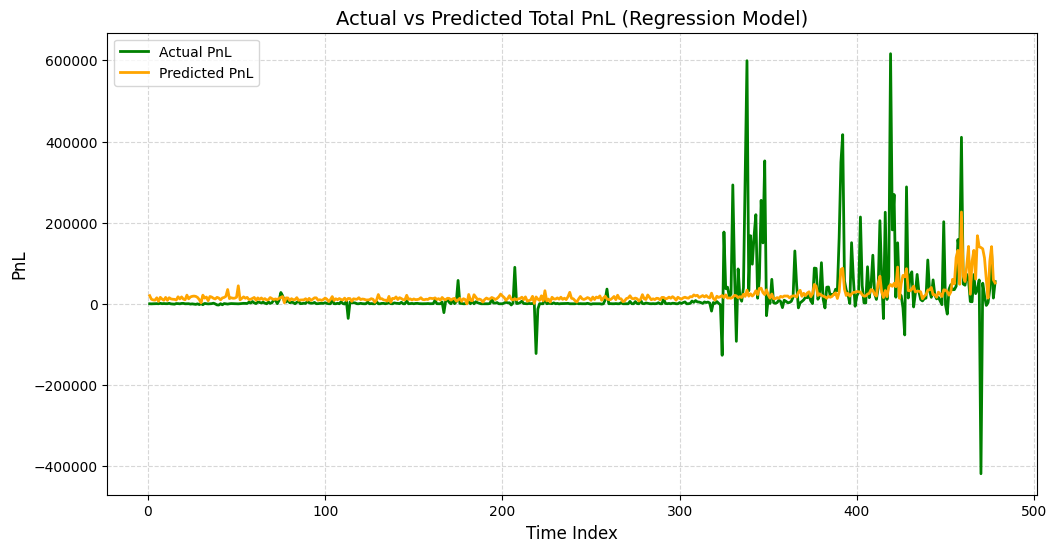

In [70]:

plt.figure(figsize=(12, 6))
plt.plot(regression_data.index, y, label='Actual PnL', color='green', linewidth=2, markersize=4)
plt.plot(regression_data.index, regression_data['predicted_pnl'], label='Predicted PnL', color='orange', linewidth=2, markersize=4)

plt.title('Actual vs Predicted Total PnL (Regression Model)', fontsize=14)
plt.xlabel('Time Index', fontsize=12)
plt.ylabel('PnL', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.savefig('/content/ds_SauravBhadange/outputs/regression_actual_vs_predicted.png', bbox_inches='tight')
plt.show()

regression_data.to_csv('/content/ds_SauravBhadange/csv_files/regression_results.csv', index=False)


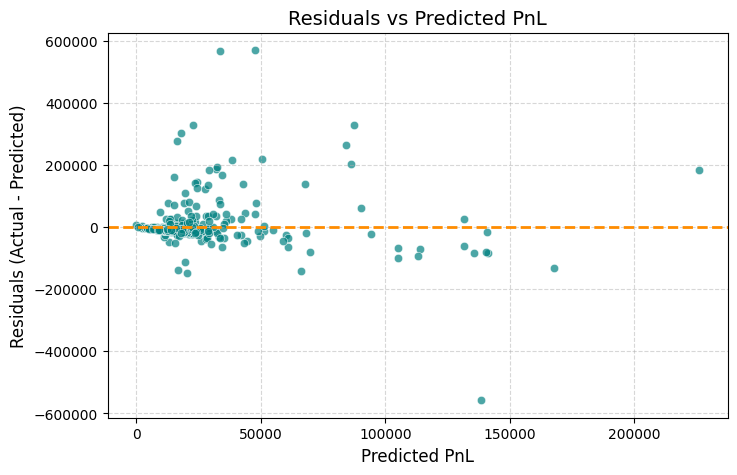

In [71]:
residuals = y - regression_data['predicted_pnl']
plt.figure(figsize=(8, 5))
sns.scatterplot(x=regression_data['predicted_pnl'], y=residuals, color='teal', alpha=0.7)
plt.axhline(y=0,color='darkorange',linestyle='--',linewidth=2)
plt.title('Residuals vs Predicted PnL', fontsize=14)
plt.xlabel('Predicted PnL', fontsize=12)
plt.ylabel('Residuals (Actual - Predicted)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('/content/ds_SauravBhadange/outputs/regression_residuals.png', bbox_inches='tight')
plt.show()


In [72]:
insights = []

sentiment_corr = corr['sentiment_norm'].drop('sentiment_norm').sort_values(ascending=False)
top_metric = sentiment_corr.index[0]
top_corr_value = sentiment_corr.iloc[0]
insights.append(
    f"Strongest correlation with market sentiment: {top_metric} (corr = {top_corr_value:.2f})."
)
fear_periods = merged_df[merged_df['sentiment_score'] < 50]
greed_periods = merged_df[merged_df['sentiment_score'] >= 50]
avg_pnl_fear = fear_periods['total_pnl'].mean()
avg_pnl_greed = greed_periods['total_pnl'].mean()
if avg_pnl_fear > avg_pnl_greed:
    insights.append(
        f"Traders were more profitable during FEAR (Avg PnL = {avg_pnl_fear:.2f}) "
        f"compared to GREED (Avg PnL = {avg_pnl_greed:.2f})."
    )
else:
    insights.append(
        f"Traders earned more during GREED (Avg PnL = {avg_pnl_greed:.2f}) "
        f"compared to FEAR (Avg PnL = {avg_pnl_fear:.2f})."
    )

for insight in insights:
    print(insight)


Strongest correlation with market sentiment: price_risk (corr = -0.06).
Traders were more profitable during FEAR (Avg PnL = 37597.94) compared to GREED (Avg PnL = 14988.82).


In [73]:
merged_df['sentiment_next'] = merged_df['sentiment_norm'].shift(-1)

lead_corr = merged_df[['price_risk', 'sentiment_next']].corr().iloc[0, 1]

if abs(lead_corr) > 0.3:
    insights.append(f"Price risk appears to lead market sentiment (corr = {lead_corr:.2f}).")

print("\n=== Key Insights ===")
for insight in insights:
    print("-", insight)



=== Key Insights ===
- Strongest correlation with market sentiment: price_risk (corr = -0.06).
- Traders were more profitable during FEAR (Avg PnL = 37597.94) compared to GREED (Avg PnL = 14988.82).


In [74]:
merged_df.to_csv('/content/ds_SauravBhadange/csv_files/trader_sentiment_analysis.csv', index=False)